In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import os

from statsmodels.tsa.arima.model import ARIMA

In [62]:
df = pd.read_csv('cleaned_hospital.csv')

In [63]:
grouped = df.groupby(['Year', 'APR DRG Code']).agg({
    'Discharges': 'sum'
}).reset_index()

actual_vs_predicted = {}

os.makedirs('q2_models', exist_ok=True)

for drg in grouped['APR DRG Code'].unique():
    drg_data = grouped[grouped['APR DRG Code'] == drg].sort_values('Year')
    drg_data.set_index('Year', inplace=True)

    if drg_data.shape[0] >= 10:
        train = drg_data.loc[2009:2016]
        test_actual = drg_data.loc[2017, 'Discharges'] if 2017 in drg_data.index else None

        if test_actual is not None:
            try:
                model = ARIMA(train['Discharges'], order=(1, 1, 1))
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=1)
                predicted = forecast.values[0]
                actual_vs_predicted[drg] = (test_actual, predicted)

            except:
                actual_vs_predicted[drg] = (test_actual, None)


results_df = pd.DataFrame.from_dict(actual_vs_predicted, orient='index', columns=['Actual', 'Predicted'])

print(results_df.head(30))
print(f"\nTotal DRGs available: {results_df.shape[0]}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/

     Actual     Predicted
1     394.0    355.616788
2     265.0    216.842447
4    4118.0   4753.172432
5    1812.0   1918.122547
6      40.0     51.597407
20   1172.0   1091.351124
21   8554.0   8524.433014
22   1303.0   1215.767224
23   1993.0   5814.599917
24   7151.0   6613.712710
26   1418.0   1837.701947
40   1066.0   1562.807816
41   3627.0   3783.051409
42   6403.0   6190.281987
43   2338.0   2376.378599
44   5264.0   5243.708433
45  25846.0  26063.610991
46    991.0    811.421657
47   7842.0   8853.652851
48   5427.0   5345.490926
49    939.0    956.653206
50   1306.0   1398.135619
51    679.0    893.153876
52   5897.0   5781.462889
53  25766.0  25220.527770
54   4769.0   4996.834294
55   6842.0   6400.974560
56    173.0   -402.246949
57   2320.0   2302.992086
58  17842.0  17111.332577

Total DRGs available: 292


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base

<Figure size 1400x600 with 0 Axes>

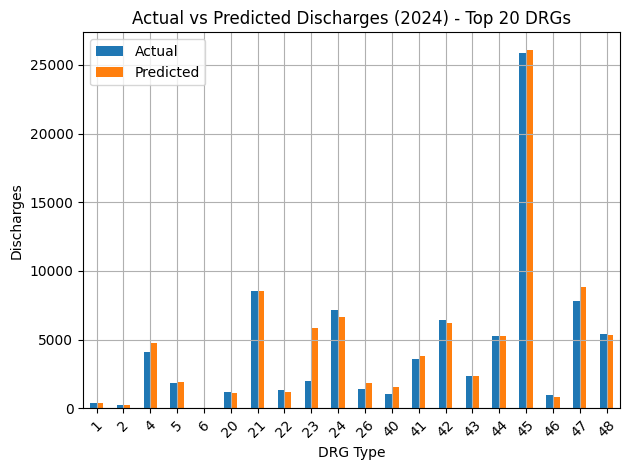

In [64]:
results_df = results_df.dropna()

results_df = results_df.reset_index().rename(columns={'index': 'DRG'})

results_df['Actual'] = pd.to_numeric(results_df['Actual'], errors='coerce')
results_df['Predicted'] = pd.to_numeric(results_df['Predicted'], errors='coerce')

results_df = results_df.dropna()

plt.figure(figsize=(14,6))
subset = results_df.head(20)
subset.plot(x='DRG', y=['Actual', 'Predicted'], kind='bar')
plt.title('Actual vs Predicted Discharges (2024) - Top 20 DRGs')
plt.xlabel('DRG Type')
plt.ylabel('Discharges')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
actual = results_df['Actual']
predicted = results_df['Predicted']

mse = mean_squared_error(actual, predicted)
rmse = mse ** 0.5
r2 = r2_score(actual, predicted)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MSE: 1189211.77
RMSE: 1090.51
R² Score: 0.9957
